# About the experiment

Aim:
1. Determine if crosstalk causes phase noise errors(Z-flips) or amplitude noise errors(X-flips).
2. Determine how snooping time window effects our ability to detect CNOTs

Backend: IBM Lagos \
Victim Qubits: (3, 5) \
Victim CNOTs applied: [ (3, 5) ] \
Attacker Qubits: (0, 1, 2, 4, 6)

# Imports

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
from qiskit_ibm_provider import IBMProvider

from qiskit.transpiler import PassManager, Layout
from qiskit.transpiler.passes import SetLayout, ApplyLayout, ASAPSchedule
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

import attacker

# Parameters

In [2]:
ibm_backend_name = 'ibm_lagos'
victim_qubit_indices = (3, 5)
attack_qubit_indices = (0, 1, 2, 4, 6)
cx_delay_dt = 4320
victim_initial_delay = 160

In [3]:
snooping_durations_dt = []
temp_cx_delay_dt = cx_delay_dt
while temp_cx_delay_dt > 160:
    snooping_durations_dt.append(temp_cx_delay_dt)
    temp_cx_delay_dt //= 2

snooping_durations_dt.reverse()

print(snooping_durations_dt)
print(len(snooping_durations_dt))

[270, 540, 1080, 2160, 4320]
5


# Create Circuits

## Victim Circuit

In [4]:
victim_qregs = QuantumRegister(2)

In [5]:
blank_victim_circ = QuantumCircuit(victim_qregs, name="Blank Victim Circ")

In [6]:
victim_qc_with_cnot = QuantumCircuit(victim_qregs, name="Victim Circ")
victim_qc_with_cnot.cx(victim_qregs[0], victim_qregs[1])

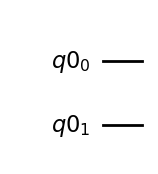

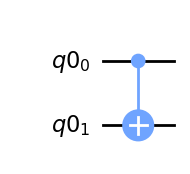

In [7]:
display(blank_victim_circ.draw('mpl'))
display(victim_qc_with_cnot.draw('mpl'))

## Attack Circuits

In [8]:
attack_qregs = QuantumRegister(5)
attack_cregs = ClassicalRegister(5)
snooping_duration_param = Parameter("snooping_duration")

In [9]:
attack_qc_z_flips = QuantumCircuit(attack_qregs, attack_cregs, name="Attack Circ")
attack_qc_z_flips.delay(snooping_duration_param)
attack_qc_z_flips.measure(attack_qregs, attack_cregs)

In [10]:
attack_qc_x_flips = QuantumCircuit(attack_qregs, attack_cregs)
attack_qc_x_flips.h(attack_qregs)
attack_qc_x_flips.delay(snooping_duration_param)
attack_qc_x_flips.h(attack_qregs)
attack_qc_x_flips.measure(attack_qregs, attack_cregs)

## Full Circuits

In [11]:
full_qcs = []
qregs = QuantumRegister(7)
cregs = ClassicalRegister(5)

initial_qc = QuantumCircuit(qregs, cregs)

for victim_qc in [blank_victim_circ, victim_qc_with_cnot]:
    for attack_qc in [attack_qc_z_flips, attack_qc_x_flips]:
        for snooping_duration_dt in snooping_durations_dt:
            qc = initial_qc.compose(victim_qc, qregs[0:2])
            qc = qc.compose(attack_qc.bind_parameters({snooping_duration_param: snooping_duration_dt}), qregs[2:])
            full_qcs.append(qc)

In [12]:
layout_dict = { }

for qreg, index in zip(qregs[0:2], victim_qubit_indices):
    layout_dict[qreg] = index

for qreg, index in zip(qregs[2:], attack_qubit_indices):
    layout_dict[qreg] = index

layout_dict

{Qubit(QuantumRegister(7, 'q2'), 0): 3,
 Qubit(QuantumRegister(7, 'q2'), 1): 5,
 Qubit(QuantumRegister(7, 'q2'), 2): 0,
 Qubit(QuantumRegister(7, 'q2'), 3): 1,
 Qubit(QuantumRegister(7, 'q2'), 4): 2,
 Qubit(QuantumRegister(7, 'q2'), 5): 4,
 Qubit(QuantumRegister(7, 'q2'), 6): 6}

# Compile experiments

In [13]:
try:
    print(provider)
except NameError:
    provider = IBMProvider()

In [14]:
backend = provider.get_backend(ibm_backend_name)
# config = backend.configuration()
# props = backend.properties()

In [15]:
pm = generate_preset_pass_manager(0, backend)
layout = Layout(layout_dict)
pm.layout = PassManager([
    SetLayout(layout),
    ApplyLayout()
])

pm.scheduling = PassManager([
    ASAPSchedule(backend.instruction_durations)
])

In [16]:
full_tqcs = pm.run(full_qcs)

In [17]:
len(full_tqcs)

20

## Timeline Viewer

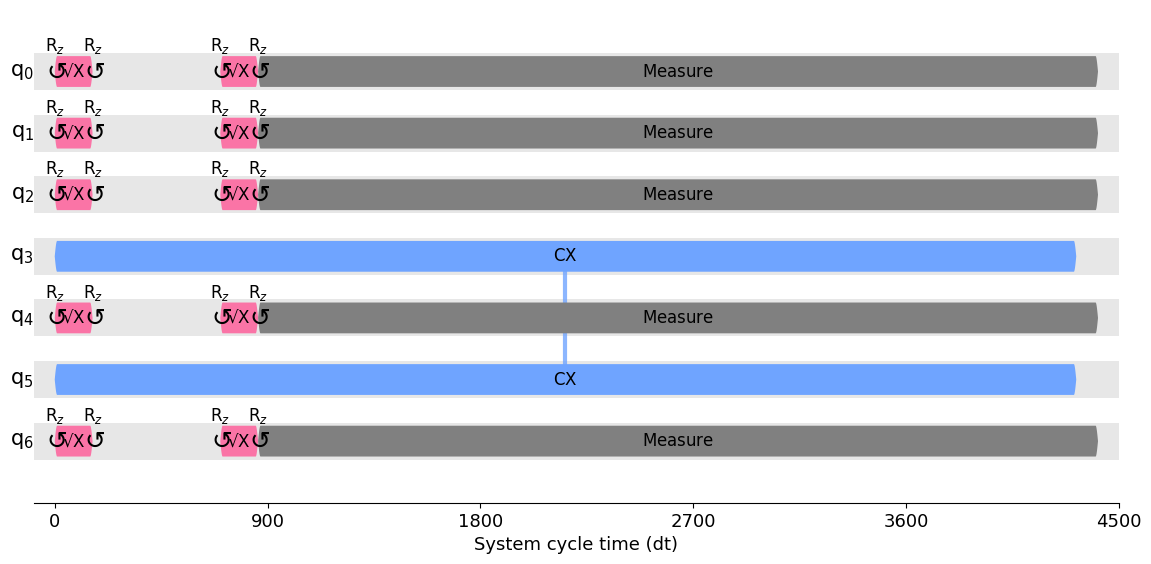

In [40]:
from qiskit.visualization import timeline_drawer

i = 16
display(timeline_drawer(full_tqcs[i]))

# Submit Job

In [41]:
job = backend.run(full_tqcs, shots=8000)
job.update_tags(['snooping', 'exp_1'])
print('New job: ', job.job_id())

New job:  cmjc84g0t6t00085yc40
